# ALS HD demo scene

Notebook creator: Sina Zumstein & Hannah Weiser, 2022

This demo scene uses a digital terrain model (DTM) of Heidelberg, Germany, which will be scanned by airborne laser scanning (ALS). We will use the command-line access of HELIOS++ to run the simulation, and use Python just for displaying the input XMLs and the resulting point clouds.

In [1]:
from pathlib import Path
from IPython.display import Code
from pyhelios.util.xmldisplayer import display_xml, find_playback_dir

In [2]:
import os
os.chdir("..")

## Survey
Let us look at the XML files in the simulation. First, we investigate the **survey** XML file, `als_hd_demo_tiff.xml`:

In [3]:
Code(display_xml('data/surveys/demo/als_hd_demo_tiff.xml'), language='XML')

<document>
	<!-- default scanner settings -->
	<scannerSettings id="set" active="true" pulseFreq_hz="70000" scanAngle_deg="60" scanFreq_hz="50" />
    <survey name="als_hd_demo" scene="data/scenes/demo/hd_demo.xml#hd_demo" platform="data/platforms.xml#sr22" scanner="data/scanners_als.xml#riegl_vq-1560i">
	<!-- platform: Plane, deflector: oscillating -->
        <FWFSettings beamSampleQuality="3" binSize_ns="0.25" winSize_ns="1" />
        <detectorSettings rangeMax_m="1700" />

		<leg>
			<platformSettings x="474500" y="5474500" z="1500.000" onGround="false" movePerSec_m="150" />
			<scannerSettings template="set" trajectoryTimeInterval_s="0.05" />
		</leg>
		
		<leg>
			<platformSettings x="490000" y="5474500" z="1500.000" onGround="false" movePerSec_m="150" />
			<scannerSettings template="set" trajectoryTimeInterval_s="0.05" />
		</leg>

		<leg>
			<platformSettings x="474500" y="5473500" z="1500.000" onGround="false" movePerSec_m="150" />
			<scannerSettings template="set" trajectoryTimeInterval_s="0.05" />
		</leg>
		
<!--		<leg>-->
<!--			<platformSettings  x="490000" y="5473500" z="1500.000" onGround="false" movePerSec_m="150"/>-->
<!--			<scannerSettings  active="false"/>-->
<!--		</leg>-->

    </survey>
</document>

We can see that there are four `leg` elements which define the waypoints of the airplane trajectory with `x`, `y`, `z` coordinates and the speed between these waypoints (`movePerSec_m`). This results in three flight lines.
Furthermore, we see that the `sr22` platform in `data/platforms.xml` is referenced, so let's have a look at that next:

## Platform

In [4]:
Code(display_xml('python/pyhelios/data/platforms.xml', 'sr22'))

<platform id="sr22" name="Cirrus SR-22" type="linearpath">
		<scannerMount z="0.7">
			<rot axis="x" angle_deg="-90" />
			<rot axis="z" angle_deg="90" />
		</scannerMount>
		<!--<positionXNoise
			clipMin="0.0" clipMax="0.0" clipEnabled="false" fixedLifespan="1"
			type="NORMAL" mean="0.0" stdev="0.02"/>
		<positionYNoise
			clipMin="0.0" clipMax="0.0" clipEnabled="false" fixedLifespan="1"
			type="NORMAL" mean="0.0" stdev="0.02"/>
		<positionZNoise
			clipMin="0.0" clipMax="0.0" clipEnabled="false" fixedLifespan="1"
			type="NORMAL" mean="0.0" stdev="0.02"/>
		<attitudeXNoise
			clipMin="0.0" clipMax="0.0" clipEnabled="false" fixedLifespan="1"
			type="NORMAL" mean="0.0" stdev="0.001"/>
		<attitudeYNoise
			clipMin="0.0" clipMax="0.0" clipEnabled="false" fixedLifespan="1"
			type="NORMAL" mean="0.0" stdev="0.001"/>
		<attitudeZNoise
			clipMin="0.0" clipMax="0.0" clipEnabled="false" fixedLifespan="1"
			type="NORMAL" mean="0.0" stdev="0.001"/>-->
	</platform>

This is a `linearpath` type platform, a mobile platform which moves in a straight line between consecutive legs with a constant speed provided by the user.

Without any rotations applied to the `scannerMount` in the platform XML or the `beamOrigin` in the scanner XML, scanners in HELIOS would face towards to Y-axis (forward) and scan in vertical scan lines (in the plane created by the Y- and Z-axis). 

For the `sr22`, the `scannerMount` is configured so that the scanner is rotated -90° around the X-axis (facing downwards) and 90° around the Z-axis (scanning from left to right, i.e., in the plane created by the X- and Z-axes).

For more information and examples, check out the [rotations section](https://github.com/3dgeo-heidelberg/helios/wiki/Platforms#rotations) of the Wiki page on platforms.

## Sanner

Next we will have a look at the scanner that is placed on the platform. Here it is the `leica_als50-ii` defined in `data/scanners_als.xml` as shown in the survey XML.

In [5]:
Code(display_xml('python/pyhelios/data/scanners_als.xml', 'riegl_vq-1560i'), language='XML')

<scanner id="riegl_vq-1560i" accuracy_m="0.02" beamDivergence_rad="0.0007" name="RIEGL VQ-1560i (Dual-Channel)" optics="rotating" pulseFreqs_Hz="150000,250000,350000,500000,700000,1000000,2000000" pulseLength_ns="4" rangeMin_m="0.0100" scanAngleMax_deg="45" scanAngleEffectiveMax_deg="30" scanFreqMin_Hz="40" scanFreqMax_Hz="600" wavelength_nm="532">
				
		<FWFSettings beamSampleQuality="3" />	
		<channels>
			<channel id="0">
				<beamOrigin x="0" y="0.0" z="0.0">				
					<rot axis="y" angle_deg="14" />					
				</beamOrigin>
			</channel>
			<channel id="1">
				<beamOrigin x="0" y="0.0" z="0.0">					
					<rot axis="y" angle_deg="-14" />					
				</beamOrigin>
			</channel>
		</channels>

	</scanner>

Here we can see the scanner-specific settings, for example the `beamDivergence_rad`, the `accuracy` or the possible pulse frequencies (`pulseFreq_Hz`). The Leica ALS50-II has an oscillating beam deflector (`optics`) and is capable of recording up to 4 returns per emitted pulse (`maxNOR`).

## Scene

Now we will have a look at the scene, `hd_demo.xml`in `data/scenes/demo/hd_demo.xml`:

In [6]:
Code(display_xml('data/scenes/demo/hd_demo.xml', 'hd_demo'))

<scene id="hd_demo" name="Heidelberg">
        <part>
            <filter type="geotiffloader">
                <param type="string" key="filepath" value="data/sceneparts/tiff/dem_hd.tif" />
            </filter>
        </part>
    </scene>

Here we see one object, which is a digital elevation model (DEM) of Heidelberg (Germany) in GeoTIFF file format. To load it, we use the `geotiffloader` filter and give the relative path to the file in the `filepath` parameter.

## Executing the Simulation

Next, we will run the simulation. In Jupyter Notebooks, we can run external commands with the `!command` syntax, but you can also just run it from the command line.

In [ ]:
!helios data/surveys/demo/als_hd_demo_tiff.xml -q

## The results 
Now we can display a couple of 2D plots of the simulated point cloud.

We first load the output files to numpy arrays.

In [8]:
import numpy as np
import matplotlib.pyplot as plt

output_path = find_playback_dir('data/surveys/demo/als_hd_demo_tiff.xml')

print('Loading points from', Path(output_path))

strip_1 = np.loadtxt(Path(output_path) / 'leg000_points.xyz')
strip_2 = np.loadtxt(Path(output_path) / 'leg001_points.xyz')
strip_3 = np.loadtxt(Path(output_path) / 'leg002_points.xyz')
traj_1 = np.loadtxt(Path(output_path) / 'leg000_trajectory.txt')
traj_2 = np.loadtxt(Path(output_path) / 'leg001_trajectory.txt')
traj_3 = np.loadtxt(Path(output_path) / 'leg002_trajectory.txt')
traj = np.vstack((traj_1[:, :3], traj_2[:, :3], traj_3[:, :3]))

Loading points from C:\Users\Ethan\Desktop\helios\output\als_hd_demo\2025-05-01_19-25-39


Now we create two plots - one from above and one from the side - showing the point cloud colored by flight strip and the trajectory.

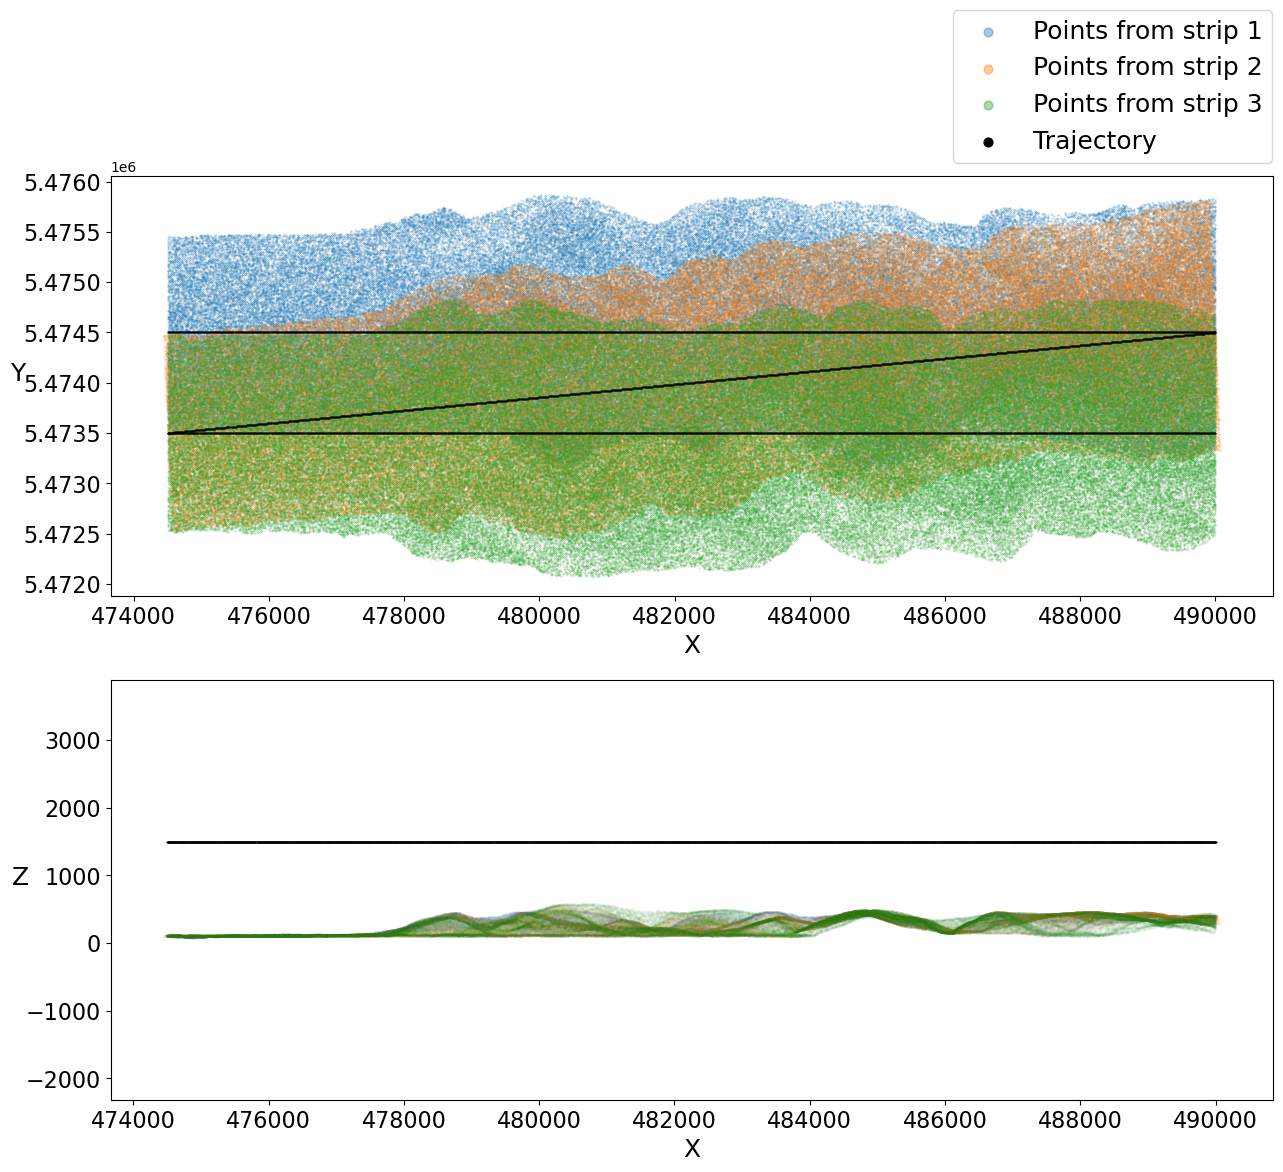

In [9]:
# two subplots
fig, (ax1, ax2) = plt.subplots(2, figsize=(15, 12))

# view from above, colored by strip, including trajectory - for faster display, show only every 25th measurement
ax1.scatter(strip_1[::25, 0], strip_1[::25, 1], s=0.1, alpha=0.4, label="Points from strip 1") # select X and Y coordinates
ax1.scatter(strip_2[::25, 0], strip_2[::25, 1], s=0.1, alpha=0.4, label="Points from strip 2")
ax1.scatter(strip_3[::25, 0], strip_3[::25, 1], s=0.1, alpha=0.4, label="Points from strip 3")
ax1.scatter(traj[:, 0], traj[:, 1], s=0.1, label="Trajectory", color="black")
ax1.tick_params(labelsize=16)
ax1.set_xlabel('X', fontsize=18)
ax1.set_ylabel('Y', fontsize=18, rotation=0)
ax1.legend(fontsize=18, markerscale=20, loc="lower right", bbox_to_anchor=(1.01, 1))

# use only every 50th measurement for better display
ax2.scatter(strip_1[::50, 0], strip_1[::50, 2], alpha=0.05, s=0.1, label="Points from strip 1") # select X and Z coordinates
ax2.scatter(strip_2[::50, 0], strip_2[::50, 2], alpha=0.05, s=0.1, label="Points from strip 2")
ax2.scatter(strip_3[::50, 0], strip_3[::50, 2], alpha=0.05, s=0.1, label="Points from strip 3")
ax2.scatter(traj[:, 0], traj[:, 2], s=0.05, label="Trajectory", color="black")
ax2.tick_params(labelsize=16)
ax2.set_xlabel('X', fontsize=18)
ax2.set_ylabel('Z', fontsize=18, rotation=0)

plt.axis('equal')
#plt.legend(fontsize=18, markerscale=20)
plt.show()

Let's create another plot from above which is colored by altitude.

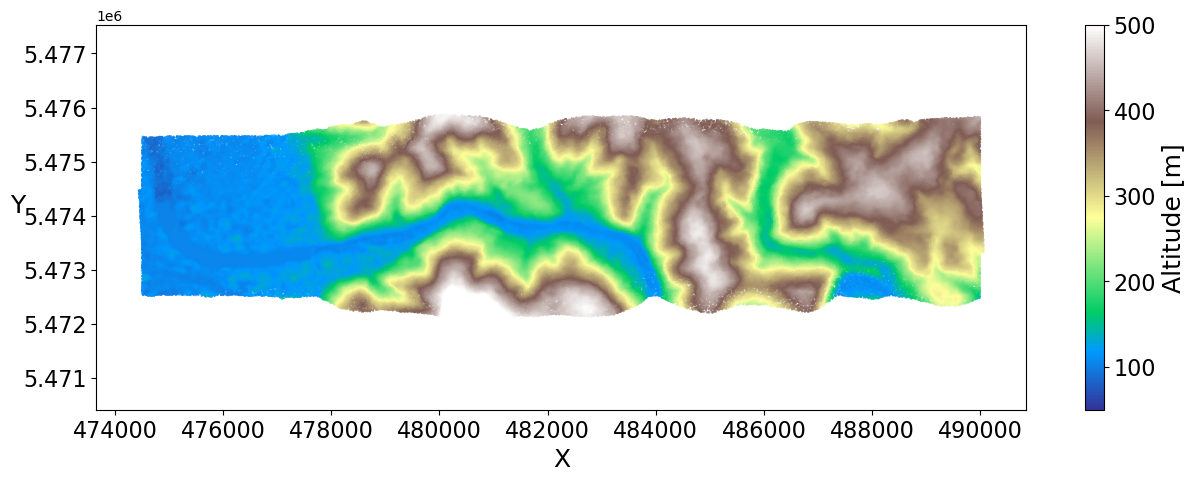

In [10]:
#view from above - colored by altitude

fig, ax = plt.subplots(figsize=(15, 5))

# select X and y coordinates
plot1 = ax.scatter(strip_1[::20, 0], strip_1[::20, 1], s=0.1, c=strip_1[::20,2], cmap= 'terrain', vmin=50, vmax=500)
plot2 = ax.scatter(strip_2[::20, 0], strip_2[::20, 1], s=0.1, c=strip_2[::20,2], cmap= 'terrain', vmin=50, vmax=500)
plot3 = ax.scatter(strip_3[::20, 0], strip_3[::20, 1], s=0.1, c=strip_3[::20,2], cmap= 'terrain', vmin=50, vmax=500)
plt.axis('equal')
ax.tick_params(labelsize=16)
plt.xlabel('X', fontsize=18)
plt.ylabel('Y', fontsize=18, rotation=0)

cbar = plt.colorbar(plot1)
cbar.ax.tick_params(labelsize=16)
cbar.set_label('Altitude [m]', fontsize=18)
plt.show()

Finally, plot only a section of the point cloud to get a profile of the Neckar valley in Heidelberg.

In [11]:
# Section in direction of Y 

xmin, ymin, xmax, ymax = [480000, 5472000, 480100, 5476000]

section_1 = strip_1[(strip_1[:, 0] > xmin) & 
                    (strip_1[:, 0] < xmax) & 
                    (strip_1[:, 1] > ymin) & 
                    (strip_1[:, 1] < ymax)]
section_2 = strip_2[(strip_2[:, 0] > xmin) & 
                    (strip_2[:, 0] < xmax) & 
                    (strip_2[:, 1] > ymin) & 
                    (strip_2[:, 1] < ymax)]
section_3 = strip_3[(strip_3[:, 0] > xmin) & 
                    (strip_3[:, 0] < xmax) & 
                    (strip_3[:, 1] > ymin) & 
                    (strip_3[:, 1] < ymax)]

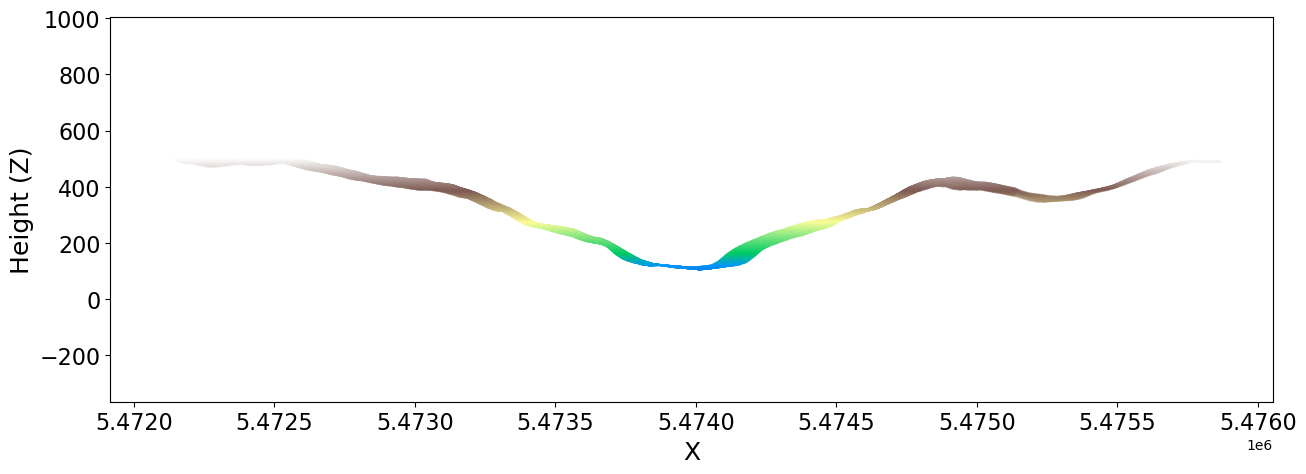

In [12]:
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot()

ax.scatter(section_1[:, 1], section_1[:, 2], c=section_1[:, 2], cmap='terrain', s=0.01, vmin=50, vmax=500)
ax.scatter(section_2[:, 1], section_2[:, 2], c=section_2[:, 2], cmap='terrain', s=0.01, vmin=50, vmax=500)
ax.scatter(section_3[:, 1], section_3[:, 2], c=section_3[:, 2], cmap='terrain', s=0.01, vmin=50, vmax=500)
ax.tick_params(labelsize=16)

plt.xlabel('X', fontsize=18)
plt.ylabel('Height (Z)', fontsize=18, rotation=90)
plt.axis('equal')
plt.show()